In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import altair as alt
from glob import glob
from tqdm import tqdm_notebook

In [2]:
!pwd

/Users/khant/JaX_work/g4API_app/cd2k_llmWorkShop/notebook


In [4]:
runDir ="/Users/khant/JaX_work/g4API_app/FBS_tumorOrganoid/FBS_tumorOrganoid/"
prompt = json.load(open(runDir+"param/FGF_param.json","r"))

In [5]:
prompt

{'background': ['gene name', 'Brief summary'],
 'scoring_strategy': 'Generate a score from 0 to 10 for each of the following statements based on the available evidence from the scientific literature',
 'model_setting': {'temperature': 0.7, 'q_iter': 1},
 'question': ['The gene is associated with the biological functions or signaling pathways of Fibroblast Growth Factor. Score: Based on evidence linking the gene to the various cellular processes and signaling cascades regulated by Fibroblast Growth Factor, such as cell proliferation, differentiation, migration, angiogenesis, and wound healing.',
  "The gene's expression is regulated by Fibroblast Growth Factor signaling. Score: Based on evidence demonstrating that the gene's transcription is modulated in response to Fibroblast Growth Factor stimulation or inhibition, suggesting a direct or indirect regulatory relationship",
  "The gene's product interacts with Fibroblast Growth Factor or Fibroblast Growth Factor receptors. Score: Based 

In [6]:
!cat {runDir}"outResults_g4/resp_MGA.json"

{
    "datasvc-openai-compsci-poc-gpt4-turbo_1": [
        "```json",
        "{",
        "  \"gene_name\": \"MGA\",",
        "  \"brief_summary\": \"The gene MGA, which stands for 'MAX Gene Associated,' encodes a protein that is a member of the MAX (MYC associated factor X) network of transcriptional regulators. This protein is involved in complex cellular processes, including regulation of gene expression, cell cycle progression, and possibly also chromatin remodeling. It has been implicated in the control of cellular growth and differentiation and may play a role in tumor suppression.\",",
        "  \"evidence_scores\": {",
        "    \"The gene is associated with the biological functions or signaling pathways of Fibroblast Growth Factor.\": 1,",
        "    \"The gene's expression is regulated by Fibroblast Growth Factor signaling.\": 2,",
        "    \"The gene's product interacts with Fibroblast Growth Factor or Fibroblast Growth Factor receptors.\": 0",
        "  }",
   

In [7]:
# define key dictionary for each question for concrete formatting
import re
mainkey_qestion_key = {'summary':'Summary','Brief_summary':'Summary',
                       "gene_name":'geneSymbol',
               'associated with':'a_associated_FGF',
                'expression is regulate':'b_regulates_FGF',
                'interacts with':'c_Interacts_FGF',
               }


In [8]:



def find_keyword(sline, keyLib):
    for mk in keyLib.keys():

        # Regular expression pattern to find all combinations of the letters in 'gene'
        pattern = r'{}'.format(mk)

        # Finding all matches in the sample text
        matches = re.findall(pattern, sline, re.IGNORECASE)
        if matches:
            return keyLib[mk]
        else:
            next
    return False



def convert_stringtodict(lines, keylib):
    dict_line = {}
    for k in lines:
        ksplit = k.split(":")

        if len(ksplit) ==2:
            key_tmp = find_keyword(ksplit[0].strip("\'|\"|', |").strip(), keylib)
            val_tmp = ksplit[1].strip("\'|\"|',|{|} ").strip()
            if key_tmp and val_tmp:
                if (key_tmp == "Summary") | (key_tmp == "geneSymbol"):
                    dict_line[key_tmp] = val_tmp
                else:
                    try:
                        dict_line[key_tmp] = float(val_tmp)
                    except:
                        dict_line[key_tmp] = 0
            else:
                next
                # print ("error in ", ksplit)

    return dict_line

def truncate_json_at_time(filepath):
    with open(filepath, 'r') as file:
        content = file.read()

    # Find the index of the first occurrence of "time"
    time_index = content.find('"time"')
    if time_index != -1:
        # Find the index of the next "}" after "time"
        end_index = content.find('}', time_index)
        if end_index != -1:
            # Truncate the content after the "}"
            content = content[:end_index + 1]
            return content
    return "Time key not found or missing closing brace."

In [9]:
outdirPath = runDir+"outResults_g4/"
!ls {outdirPath} | wc -l

    9870


In [10]:
outdirPath = runDir+"outResults_g4/"
responseDF = []
error_JSON = []

for k in tqdm_notebook(glob(outdirPath+"resp_*.json")):
    gene_name = k.split("/")[-1].split("_")[-1].split(".")[0]
    try:
        response = json.load(open(k,'r'))
        response_keys = list(response.keys())
        tx = convert_stringtodict(response[response_keys[0]],mainkey_qestion_key)
        tx.update({'time':response['time'],'model':response_keys[0],'geneName':gene_name})
        responseDF.append(tx)
    except:
        try:
            truncated_json = json.loads(truncate_json_at_time(k))
            response_keys = list(truncated_json.keys())
            tx = convert_stringtodict(truncated_json[response_keys[0]],mainkey_qestion_key)
            tx.update({'time':response['time'],'model':response_keys[0],'geneName':gene_name})
            responseDF.append(tx)
        except:
            error_JSON.append([gene_name,k])
print ("success:",len(responseDF),"\nerror :",len(error_JSON))

/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_38929/44551471.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(glob(outdirPath+"resp_*.json")):


  0%|          | 0/9870 [00:00<?, ?it/s]

success: 9870 
error : 0


In [11]:
FGF_responseDF = pd.DataFrame(responseDF).set_index("geneName")
print (FGF_responseDF.shape)

(9870, 7)


Text(5.069444444444452, 0.5, '# genes')

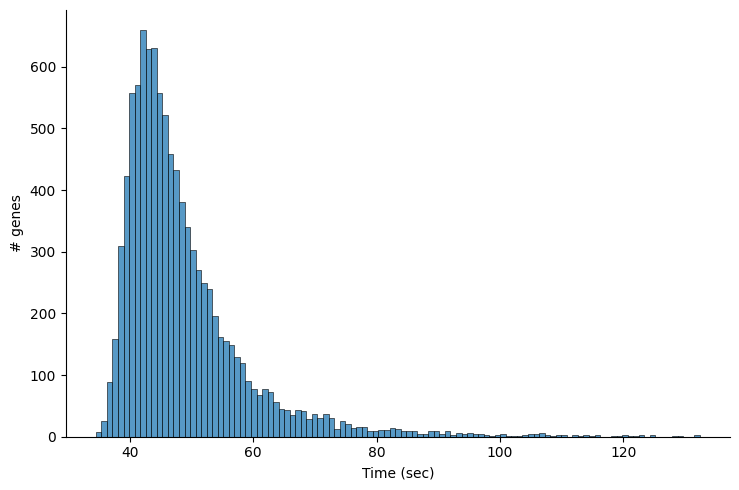

In [12]:
sns.displot(x="time",data=FGF_responseDF,aspect=1.5)
plt.xlabel("Time (sec)")
plt.ylabel("# genes")


In [13]:
FGF_responseDF.head()

,geneSymbol,Summary,a_associated_FGF,b_regulates_FGF,c_Interacts_FGF,time,model
geneName,,,,,,,
SYTL4,SYTL4,"SYTL4, also known as Synaptotagmin-Like Protei...",2.0,1.0,1.0,39.272612,datasvc-openai-compsci-poc-gpt4-turbo_1
OTUD6B,OTUD6B,"OTUD6B, also known as OTU domain-containing pr...",2.0,1.0,1.0,51.072371,datasvc-openai-compsci-poc-gpt4-turbo_1
LOC731823,LOC731823,LOC731823 is a gene identifier that may refer ...,0.0,0.0,0.0,39.048358,datasvc-openai-compsci-poc-gpt4-turbo_1
C5ORF3,C5ORF3,C5ORF3 (Chromosome 5 Open Reading Frame 3) is ...,0.0,0.0,0.0,51.512341,datasvc-openai-compsci-poc-gpt4-turbo_1
UFC1,UFC1,UFC1 (Ubiquitin-Fold Modifier Conjugating Enzy...,0.0,0.0,0.0,42.205902,datasvc-openai-compsci-poc-gpt4-turbo_1


In [48]:
FGF_responseDF.loc['2-Sep']

geneSymbol                                                      2-Sep
Summary             2-Sep is a hypothetical gene implicated in FGF...
a_associated_FGF                                                  5.0
b_regulates_FGF                                                   6.0
c_Interacts_FGF                                                   4.0
time                                                        50.099958
model                         datasvc-openai-compsci-poc-gpt4-turbo_1
Name: 2-Sep, dtype: object

In [15]:
geneBase = pd.read_csv(runDir+"data/ModuleTranscript_geneList.csv.gzip",compression="gzip").set_index("geneSymbol")
geneBase = geneBase.drop("Unnamed: 0",axis=1)
print (geneBase.shape)
geneBase.head()

(11465, 3)


,ModuleID,AggregateNumber,ModuleTitle
geneSymbol,,,
ALPP,M3.1,A29,Cell cycle
ALS2CR14,M3.1,A29,Cell cycle
ANKRD30B,M3.1,A29,Cell cycle
ARL16,M3.1,A29,Cell cycle
BCYRN1,M3.1,A29,Cell cycle


In [16]:
responseDF_geneInfo = FGF_responseDF[['geneSymbol', 'Summary',]]
responseDF_geneInfo.head()

,geneSymbol,Summary
geneName,,
SYTL4,SYTL4,"SYTL4, also known as Synaptotagmin-Like Protei..."
OTUD6B,OTUD6B,"OTUD6B, also known as OTU domain-containing pr..."
LOC731823,LOC731823,LOC731823 is a gene identifier that may refer ...
C5ORF3,C5ORF3,C5ORF3 (Chromosome 5 Open Reading Frame 3) is ...
UFC1,UFC1,UFC1 (Ubiquitin-Fold Modifier Conjugating Enzy...


In [17]:
for ikey , ival in FGF_responseDF[['geneSymbol']].iterrows():
    if not ikey == ival.geneSymbol:
        #print (ikey,ival.geneSymbol)
        responseDF_geneInfo.loc[ikey,'c_error'] = True

responseDF_geneInfo.groupby('c_error').size()

/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_38929/505304959.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  responseDF_geneInfo.loc[ikey,'c_error'] = True
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_38929/505304959.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  responseDF_geneInfo.loc[ikey,'c_error'] = True


c_error
True    462
dtype: int64

In [18]:
responseDF_geneInfo[responseDF_geneInfo.c_error==True].reset_index().drop_duplicates("geneName")

,geneName,geneSymbol,Summary,c_error
0,HS,Example Gene Name,"This is a brief summary of the gene, describin...",True
5,C6ORF170,C6orf170,C6orf170 is a gene located on chromosome 6 wit...,True
13,LMOD3,NaN,LMOD3 (Leiomodin 3) is a gene that encodes the...,True
16,C16ORF72,C16orf72,C16orf72 is a gene located on the short arm of...,True
20,IDS,Hypothetical Protein Kinase,GENE1234 encodes a hypothetical protein kinase...,True
...,...,...,...,...
439,C19ORF59,C19orf59,"C19orf59, also known as chromosome 19 open rea...",True
448,C1ORF142,C1orf142,"C1orf142, also known as 'chromosome 1 open rea...",True
451,C2ORF49,C2orf49,C2orf49 is a gene located on the second chromo...,True
454,IGLL3,NaN,IGLL3 (Immunoglobulin Lambda Like Polypeptide ...,True


In [19]:
FGF_responseDF_actGene = FGF_responseDF.loc[responseDF_geneInfo[responseDF_geneInfo.c_error.isna()].index]
print ("All genes: ", FGF_responseDF.shape[0], "\nGenes where ene id matches:", FGF_responseDF_actGene.shape[0])


All genes:  9870 
Genes where ene id matches: 9408


In [20]:
FGF_responseDF_actGene.columns

Index(['geneSymbol', 'Summary', 'a_associated_FGF', 'b_regulates_FGF',
       'c_Interacts_FGF', 'time', 'model'],
      dtype='object')

In [44]:
!pwd

/Users/khant/JaX_work/g4API_app/cd2k_llmWorkShop/notebook


In [46]:
FGF_responseDF_actGene.to_csv("../data/openAI_result_curated/FGF/scores_9408_genes.csv")

In [21]:
score_cols = ['a_associated_FGF', 'b_regulates_FGF',
       'c_Interacts_FGF']

In [22]:
FGF_responseDF_scores = FGF_responseDF_actGene[score_cols]
print (FGF_responseDF_scores.shape)

(9408, 3)


In [23]:
FGF_responseDF_scores.head()

,a_associated_FGF,b_regulates_FGF,c_Interacts_FGF
geneName,,,
SYTL4,2.0,1.0,1.0
OTUD6B,2.0,1.0,1.0
LOC731823,0.0,0.0,0.0
C5ORF3,0.0,0.0,0.0
UFC1,0.0,0.0,0.0


In [47]:
FGF_responseDF_scores.loc[FGF_responseDF_scores.index.str.contains("Sep")]

,a_associated_FGF,b_regulates_FGF,c_Interacts_FGF
geneName,,,
2-Sep,5.0,6.0,4.0


In [24]:
score_Iter = np.arange(1,10,1)
question_Iter = np.arange(1,len(score_cols),1)

print (score_Iter, question_Iter)

responseGenes = []
for s in score_Iter:
    for q in question_Iter:
        res_num = FGF_responseDF_scores[FGF_responseDF_scores[FGF_responseDF_scores>=s].fillna(0).astype(bool).sum(axis=1)>=q].shape[0]
        responseGenes.append([s,q,res_num])

responseGenesDF = pd.DataFrame(responseGenes,columns=['score','questions','genes_filtered'])

responseGenesDF

[1 2 3 4 5 6 7 8 9] [1 2]


,score,questions,genes_filtered
0,1,1,3768
1,1,2,3751
2,2,1,3206
3,2,2,1468
4,3,1,1311
5,3,2,362
6,4,1,364
7,4,2,171
8,5,1,197
9,5,2,77


### Filter 1: atleast 5 in one question

In [25]:
atL1_evd  = FGF_responseDF_scores[FGF_responseDF_scores[FGF_responseDF_scores>=5].fillna(0).astype(bool).sum(axis=1)>=1]
print (FGF_responseDF_scores.shape, atL1_evd.shape)

(9408, 3) (197, 3)


In [26]:
atL1_evd['totalScore'] = atL1_evd.sum(axis=1)
atL1_evd.sort_values(by='totalScore')
atL1_evd_annpt = atL1_evd.join(geneBase.loc[atL1_evd.index])

/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_38929/2590807127.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atL1_evd['totalScore'] = atL1_evd.sum(axis=1)


In [27]:
atL1_evd_annpt

,a_associated_FGF,b_regulates_FGF,c_Interacts_FGF,totalScore,ModuleID,AggregateNumber,ModuleTitle
geneName,,,,,,,
FGF18,9.0,7.0,8.0,24.0,M16.97,A17,Cell death
IQGAP1,5.0,4.0,3.0,12.0,M13.1,A35,Inflammation
TXN,5.0,3.0,2.0,10.0,M13.1,A35,Inflammation
PPP2R4,5.0,3.0,4.0,12.0,M15.6,A7,Cell cycle
ECT2,5.0,4.0,3.0,12.0,M15.40,A6,Gene transcription
...,...,...,...,...,...,...,...
PAK1,7.0,5.0,4.0,16.0,M15.13,A33,TBD
DUSP5,5.0,3.0,2.0,10.0,M16.3,A6,T cells
2-Sep,5.0,6.0,4.0,15.0,M13.5,A32,Cell death


In [49]:
atL1_evd_annpt.to_csv("../data/openAI_result_curated/FGF/score_filtered_at1_l5.csv")

In [28]:
print ("Unique Modules:",atL1_evd_annpt.ModuleID.nunique(),\
       "\nUnique Aggregate: ", atL1_evd_annpt.AggregateNumber.nunique(),\
        "\nUnique ModuleTitle : ", atL1_evd_annpt.ModuleTi1tle.nunique())

Unique Modules: 122 
Unique Aggregate:  26 
Unique ModuleTitle :  25


In [29]:
scoreOrder = atL1_evd_annpt.groupby('ModuleTitle')['totalScore'].agg("median").sort_values().index
titlBoxplot = alt.Chart(atL1_evd_annpt,height=200).mark_boxplot().encode(
    x=alt.X('ModuleTitle',sort=list(scoreOrder),axis=alt.Axis(title="Module Function Title",titleFontSize=10,labelFontSize=14)),
    y='totalScore'
)

module_bar = alt.Chart(atL1_evd_annpt,height=150).mark_bar().encode(
    x=alt.X('ModuleTitle',sort=list(scoreOrder),axis=alt.Axis(labels=False,title='')),
    y=alt.Y('distinct(ModuleID)',axis=alt.Axis(title="Module Count"))
)
module_text = module_bar.mark_text(
    align="center",
    baseline="middle",
    dy=-5,
    size=14
).encode(text="distinct(ModuleID)")
module_bar_plot = module_bar+module_text

gene_bar = alt.Chart(atL1_evd_annpt,height=150).mark_bar().encode(
    x=alt.X('ModuleTitle',sort=list(scoreOrder),axis=alt.Axis(labels=False,title='')),
    y=alt.Y('count(ModuleID)',axis=alt.Axis(title="Gene Count"))
)
gene_text = gene_bar.mark_text(
    align="center",
    baseline="middle",
    dy=-5,
    size=14
).encode(text="count(ModuleID)")
gene_bar_plot  = gene_bar+gene_text

alt.vconcat(gene_bar_plot,module_bar_plot, titlBoxplot).resolve_scale(
    x='shared'
)

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.VConcatChart(...)

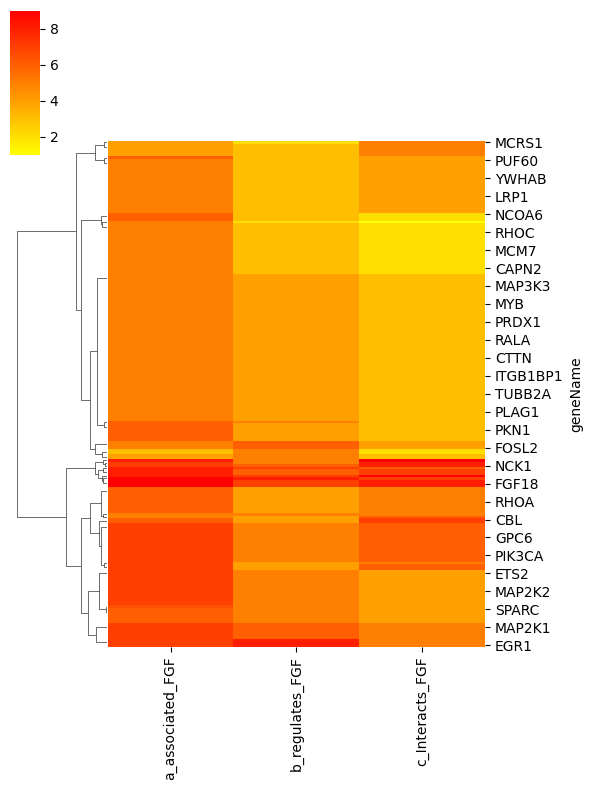

In [30]:
dataX = atL1_evd_annpt[score_cols].fillna(0)
absHM = sns.clustermap(dataX,col_cluster=False,method="ward",figsize=(6,8),cmap="autumn_r")

In [39]:
import matplotlib.colors as mcolors
from scipy.cluster.hierarchy import fcluster

figDir = "~"

def get_labelClusterMap(cData,row_linkage, spot_id_colors,heatmap_color="RdBu_r",data_scale="normalized"):
    if data_scale=="normalized":
        g = sns.clustermap(cData.fillna(0),
                    method="ward",row_cluster=True,row_linkage=row_linkage, col_cluster=False,
                    figsize=(4,8),cmap=heatmap_color,vmin=-1.5,vmax=1.5,dendrogram_ratio=0.15,
                    row_colors=spot_id_colors.c_color,
                    cbar_pos=(0.75,0.7,0.03,0.15),
                    cbar_kws={"label":'score (z-transformed)'})
    elif data_scale=="absolute":
         g = sns.clustermap(cData.fillna(0),
                    method="ward",row_cluster=True,row_linkage=row_linkage, col_cluster=False,
                    figsize=(4,8),cmap=heatmap_color,vmin=1,vmax=9,dendrogram_ratio=0.15,
                    row_colors=spot_id_colors.c_color,
                    cbar_pos=(0.75,0.7,0.03,0.15),
                    cbar_kws={"label":'score (absolute)'})
         
    g.ax_heatmap.set_yticks([])
    plt.tight_layout()
    # plt.savefig("../../../../g4API_app/bloodgen3Gensets/Sepsis/Figures/hirarchicalCluster.pdf",format="pdf")

def num_distinct_color(ncols, schema="tab10"):
    # get schema from : https://matplotlib.org/stable/users/explain/colors/colormaps.html
    # Get the 'tab10' colormap which contains 10 distinct colors
    cmap = plt.get_cmap(schema)
    # Select 6 distinct colors from the colormap
    colors = reversed([cmap(i/10) for i in range(ncols)])

    # Convert colors to hex format correctly
    return {str(cnum):mcolors.rgb2hex(color) for cnum,color in zip(np.arange(1,ncols+1),colors)}

def get_clusterMembers(gDataObj, row_linkage, numCluster=5, schema="tab10",data_scale="normalized", heatmap_color="RdBu_r"):
    # row_linkage = gDataObj.dendrogram_row.linkage
    clusters = fcluster(row_linkage, numCluster, criterion="maxclust")
    clustCols = num_distinct_color(numCluster, schema=schema)

    spot_id_cluste = []
    for spotid, clister in zip(gDataObj.data.index, clusters):
        spot_id_cluste.append([spotid,str(clister)])

    spot_id_cluste = pd.DataFrame(spot_id_cluste,columns=['spotID','c_num'])
    spot_id_cluste['c_color'] = spot_id_cluste.c_num.map(clustCols)
    spot_id_cluste = spot_id_cluste.set_index("spotID")
    get_labelClusterMap(gDataObj.data, row_linkage, spot_id_cluste, data_scale=data_scale, heatmap_color=heatmap_color)
    return spot_id_cluste

/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_38929/3400773546.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


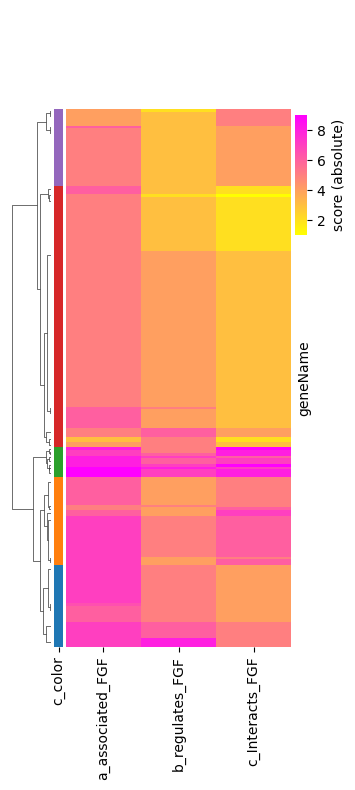

In [40]:
clustCol = get_clusterMembers(absHM,absHM.dendrogram_row.linkage, numCluster=5,schema="tab20",data_scale="absolute",heatmap_color="spring_r")

In [41]:
atL1_evd_annpt_cluster = atL1_evd_annpt.join(clustCol)

## sort cluster numbers as per popularity 
question_clusterAgg = atL1_evd_annpt_cluster.groupby('c_num')[score_cols].agg(['median','std']).\
    unstack().reset_index().pivot(index=['level_0','c_num'],columns='level_1',values=0)

question_clusterAgg = question_clusterAgg.reset_index().rename({'level_0':'questions'},axis=1)


def popularIndex(kgrp):
    return kgrp[kgrp>=5].shape[0]/kgrp.shape[0]

popularCluster = question_clusterAgg.groupby('c_num')['median'].apply(popularIndex)
popularcluserName = popularCluster.idxmax()

popularCluster = popularCluster.to_frame().sort_values(by="median",ascending=False).reset_index()
popularCluster['c_index'] = [i+1 for i in popularCluster.index]
rename_Cluster = popularCluster.set_index("c_num")['c_index'].to_dict()

print ("Populat cluster in this experiment:", popularcluserName, "\nrenaming clustes as: ", rename_Cluster)



Populat cluster in this experiment: 3 
renaming clustes as:  {'3': 1, '4': 2, '5': 3, '1': 4, '2': 5}


In [42]:
question_clusterAgg['ClusterName'] = question_clusterAgg['c_num'].map(rename_Cluster)
question_clusterAgg.head()

level_1,questions,c_num,median,std,ClusterName
0,a_associated_FGF,1,5.0,0.475595,4
1,a_associated_FGF,2,5.0,0.467238,5
2,a_associated_FGF,3,8.0,0.750757,1
3,a_associated_FGF,4,7.0,0.622171,2
4,a_associated_FGF,5,7.0,0.408600,3


In [43]:
alt.Chart(question_clusterAgg).mark_point(filled=True).encode(
    y=alt.Y('questions',axis=alt.Axis(labelFontSize=14)),
    x=alt.X('ClusterName:O'),
    color=alt.Color("median",scale=alt.Scale(scheme="redblue",reverse=True,domainMin=0.5,domainMax=8,domainMid=4,clamp=True)),
    size=alt.Size('std',scale=alt.Scale(reverse=True)),
    tooltip=["median","std"]
)

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [56]:
atL1_evd_annpt_cluster['ClusterName'] = atL1_evd_annpt_cluster['c_num'].map(rename_Cluster)
atL1_evd_annpt_cluster.head()

,a_associated_FGF,b_regulates_FGF,c_Interacts_FGF,totalScore,ModuleID,AggregateNumber,ModuleTitle,c_num,c_color,ClusterName
geneName,,,,,,,,,,
FGF18,9.0,7.0,8.0,24.0,M16.97,A17,Cell death,3,#2ca02c,1
IQGAP1,5.0,4.0,3.0,12.0,M13.1,A35,Inflammation,2,#d62728,5
TXN,5.0,3.0,2.0,10.0,M13.1,A35,Inflammation,2,#d62728,5
PPP2R4,5.0,3.0,4.0,12.0,M15.6,A7,Cell cycle,1,#9467bd,4
ECT2,5.0,4.0,3.0,12.0,M15.40,A6,Gene transcription,2,#d62728,5


In [57]:
atL1_evd_annpt_cluster.sort_values(by="c_num").to_csv("../data/openAI_result_curated/FGF/clustered_dx.csv")

In [78]:
atL1_evd_annpt_cluster= atL1_evd_annpt_cluster.sort_values(by="ClusterName")
atL1_evd_annpt_cluster


,a_associated_FGF,b_regulates_FGF,c_Interacts_FGF,totalScore,ModuleID,AggregateNumber,ModuleTitle,c_num,c_color,ClusterName
geneName,,,,,,,,,,
FGF18,9.0,7.0,8.0,24.0,M16.97,A17,Cell death,3,#2ca02c,1
SHC1,8.0,6.0,7.0,21.0,M15.103,A24,TBD,3,#2ca02c,1
SPRY2,9.0,7.0,8.0,24.0,M16.57,A5,B cells,3,#2ca02c,1
NCK1,7.0,6.0,8.0,21.0,M14.2,A2,Protein synthesis,3,#2ca02c,1
MAPK1,8.0,7.0,6.0,21.0,M13.1,A35,Inflammation,3,#2ca02c,1
...,...,...,...,...,...,...,...,...,...,...
RALA,5.0,4.0,3.0,12.0,M14.13,A2,Oxidative phosphorylation,2,#d62728,5
MMP23B,5.0,4.0,3.0,12.0,M13.21,A2,Cytotoxic lymphocytes,2,#d62728,5
CEBPB,4.0,5.0,3.0,12.0,M16.79,A35,Protein synthesis,2,#d62728,5


## Checking transcriptional profile 

In [60]:
tcgaDir = "/Users/khant/JaX_work/Manuscript/IL3_basophil/data/"
coutMat = pd.read_csv(tcgaDir+"/BRCA/count_vst.csv.gz",compression="gzip")
geneMetadata = pd.read_csv(tcgaDir+"BRCA/genemtadata.csv")#,compression="gzip")
clinicaldata = pd.read_csv(tcgaDir+"BRCA/clinicalData_brca.csv")

In [61]:
coutMat.shape

(56608, 1111)

In [62]:
coutMat

,TCGA.E9.A1RH.01A.21R.A169.07,TCGA.C8.A26W.01A.11R.A16F.07,TCGA.AO.A0JJ.01A.11R.A056.07,TCGA.BH.A0HO.01A.11R.A034.07,TCGA.BH.A18F.01A.11R.A12D.07,TCGA.C8.A12O.01A.11R.A115.07,TCGA.AQ.A04H.01B.11R.A10J.07,TCGA.BH.A0HY.01A.11R.A056.07,TCGA.B6.A40B.01A.11R.A239.07,TCGA.AO.A125.01A.11R.A10J.07,...,TCGA.AR.A1AU.01A.11R.A12P.07,TCGA.B6.A0IG.01A.11R.A034.07,TCGA.EW.A6SC.01A.12R.A32P.07,TCGA.OL.A66I.01A.21R.A29R.07,TCGA.AO.A0JE.01A.11R.A056.07,TCGA.BH.A0AU.01A.11R.A12P.07,TCGA.A8.A09G.01A.21R.A00Z.07,TCGA.E2.A14X.01A.11R.A115.07,TCGA.HN.A2OB.01A.21R.A27Q.07,TCGA.A8.A09M.01A.11R.A00Z.07
ENSG00000000003.15,8.317659,11.493085,11.762904,7.992719,11.185191,11.934615,9.817721,10.523038,11.709976,11.213214,...,10.559389,11.621664,10.776894,11.325723,11.197427,10.616204,10.930593,12.293234,12.229166,9.002776
ENSG00000000005.6,3.295686,4.613251,7.545415,4.500595,9.298130,4.161227,3.709575,5.527350,5.730850,4.544515,...,6.779428,4.715704,5.399788,6.343121,4.226369,6.216889,5.468818,4.927922,6.102252,3.295686
ENSG00000000419.13,12.497759,11.101504,10.768244,10.699482,10.832806,11.225783,11.805667,11.154133,10.845272,10.354689,...,10.523745,10.986847,10.694592,11.913702,10.953816,11.236969,11.136840,11.303933,10.234020,11.747929
ENSG00000000457.14,9.301375,10.279307,10.590663,10.742896,10.856441,9.868106,10.048104,11.312588,10.515338,11.487996,...,10.507509,10.208680,10.123693,10.515201,10.831881,10.629534,11.319552,11.217711,10.402419,10.500963
ENSG00000000460.17,9.371572,9.815603,9.143123,8.569165,9.941870,8.876841,8.771084,10.176364,9.020850,9.071821,...,8.954836,9.094940,9.137509,10.641706,9.254218,9.294787,9.634821,9.778035,8.487281,9.269172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288667.1,3.295686,3.295686,3.295686,3.295686,3.295686,3.912234,3.295686,3.295686,3.295686,3.295686,...,3.295686,3.295686,3.295686,3.295686,3.295686,3.295686,3.295686,3.295686,3.986351,3.295686
ENSG00000288669.1,3.295686,3.672870,3.295686,3.295686,3.295686,3.295686,3.295686,3.295686,3.295686,3.295686,...,3.295686,3.295686,3.295686,3.295686,3.295686,3.295686,3.295686,3.295686,3.295686,3.295686
ENSG00000288670.1,7.840500,8.308470,8.332335,8.519274,9.045389,9.065235,8.909414,9.742455,7.955163,8.863218,...,9.012841,8.122470,8.447342,8.341408,8.012761,9.322839,8.273917,9.004048,8.372048,8.115849
ENSG00000288674.1,3.295686,4.129832,4.064894,4.004582,4.111887,4.259921,4.625530,4.512346,5.047677,5.673076,...,4.462686,4.397578,4.747344,3.966747,4.426252,4.128285,4.439529,4.785084,4.787494,4.277620


In [63]:
coutMat_gname = coutMat.rename(geneMetadata["gene_name"].to_dict())

count_barcode = {}
for k in coutMat.columns:
    count_barcode[k] = "-".join(k.split(".")[:3])
    
coutMat_rename = coutMat_gname.rename(count_barcode,axis=1)

In [64]:
coutMat_rename.head()

,TCGA-E9-A1RH,TCGA-C8-A26W,TCGA-AO-A0JJ,TCGA-BH-A0HO,TCGA-BH-A18F,TCGA-C8-A12O,TCGA-AQ-A04H,TCGA-BH-A0HY,TCGA-B6-A40B,TCGA-AO-A125,...,TCGA-AR-A1AU,TCGA-B6-A0IG,TCGA-EW-A6SC,TCGA-OL-A66I,TCGA-AO-A0JE,TCGA-BH-A0AU,TCGA-A8-A09G,TCGA-E2-A14X,TCGA-HN-A2OB,TCGA-A8-A09M
TSPAN6,8.317659,11.493085,11.762904,7.992719,11.185191,11.934615,9.817721,10.523038,11.709976,11.213214,...,10.559389,11.621664,10.776894,11.325723,11.197427,10.616204,10.930593,12.293234,12.229166,9.002776
TNMD,3.295686,4.613251,7.545415,4.500595,9.298130,4.161227,3.709575,5.527350,5.730850,4.544515,...,6.779428,4.715704,5.399788,6.343121,4.226369,6.216889,5.468818,4.927922,6.102252,3.295686
DPM1,12.497759,11.101504,10.768244,10.699482,10.832806,11.225783,11.805667,11.154133,10.845272,10.354689,...,10.523745,10.986847,10.694592,11.913702,10.953816,11.236969,11.136840,11.303933,10.234020,11.747929
SCYL3,9.301375,10.279307,10.590663,10.742896,10.856441,9.868106,10.048104,11.312588,10.515338,11.487996,...,10.507509,10.208680,10.123693,10.515201,10.831881,10.629534,11.319552,11.217711,10.402419,10.500963
C1orf112,9.371572,9.815603,9.143123,8.569165,9.941870,8.876841,8.771084,10.176364,9.020850,9.071821,...,8.954836,9.094940,9.137509,10.641706,9.254218,9.294787,9.634821,9.778035,8.487281,9.269172


In [79]:
_commonGenes = set(atL1_evd_annpt_cluster.index).intersection(coutMat_rename.index)
print (len(_commonGenes))

182


In [85]:
response_pgene = atL1_evd_annpt_cluster.loc[list(_commonGenes)].sort_values(by="ClusterName")
expr_fgf = coutMat_rename.loc[list(response_pgene.index)]


In [86]:
expr_fgf

,TCGA-E9-A1RH,TCGA-C8-A26W,TCGA-AO-A0JJ,TCGA-BH-A0HO,TCGA-BH-A18F,TCGA-C8-A12O,TCGA-AQ-A04H,TCGA-BH-A0HY,TCGA-B6-A40B,TCGA-AO-A125,...,TCGA-AR-A1AU,TCGA-B6-A0IG,TCGA-EW-A6SC,TCGA-OL-A66I,TCGA-AO-A0JE,TCGA-BH-A0AU,TCGA-A8-A09G,TCGA-E2-A14X,TCGA-HN-A2OB,TCGA-A8-A09M
FRS3,7.276126,8.501020,7.652031,7.721720,8.035781,7.606301,7.487137,9.185996,9.198348,8.829461,...,8.749180,8.557215,8.559143,8.917198,7.958507,7.557396,7.121567,8.297293,8.767365,8.456250
FGFBP2,3.917085,5.007546,6.445118,4.435142,6.893464,4.636108,4.782902,4.512346,5.165318,4.192082,...,5.511872,4.469826,5.233220,5.547855,7.079571,4.771752,4.962483,7.453565,5.492623,4.177227
FGF18,7.241122,6.725313,6.522825,5.758721,7.123608,6.242683,5.627173,6.500388,6.858660,4.385211,...,5.719609,5.776444,5.680018,6.343121,7.102072,6.714545,5.321523,5.224114,7.552469,5.748840
IL17RD,10.047646,10.101902,11.369269,9.656980,12.000089,9.727976,9.691346,9.390954,9.612600,9.140996,...,11.402368,9.671930,11.158872,10.607108,8.036232,10.387859,9.741434,11.053295,12.669730,10.487724
SHC1,12.014702,12.356203,12.460974,13.234339,13.140231,12.354884,12.283430,12.831427,12.820901,12.414121,...,12.999599,12.477493,12.904961,12.542073,12.557119,13.521446,12.461031,12.336561,12.805129,13.204903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LIMK2,11.981753,11.885048,11.741787,12.360184,12.195422,13.202347,10.841630,13.492310,12.119279,11.493393,...,12.275237,12.169879,11.350827,12.068488,12.410409,11.950576,12.078361,14.527870,12.569307,12.402351
CITED2,13.166089,10.751598,13.007094,11.444055,12.312954,10.475207,12.001912,11.538792,13.689603,10.717035,...,12.151941,12.956397,14.470111,12.259447,11.181092,12.030051,12.141758,12.067274,12.720381,11.903430
SGK3,8.130109,11.080970,11.373938,10.300720,9.513109,12.237933,10.468416,8.237771,9.117928,10.808836,...,9.505646,8.680195,10.143132,10.615090,9.383226,11.797278,8.231582,9.897152,10.896546,10.332405
STK36,11.124928,10.728250,10.535237,11.081396,10.793116,10.543687,11.531641,10.412000,11.294536,12.823129,...,11.207448,10.819344,11.549646,11.295622,10.947649,11.333489,9.537165,9.873908,11.173683,11.987459


In [87]:
response_pgene

,a_associated_FGF,b_regulates_FGF,c_Interacts_FGF,totalScore,ModuleID,AggregateNumber,ModuleTitle,c_num,c_color,ClusterName
geneName,,,,,,,,,,
FRS3,8.0,6.0,7.0,21.0,M16.2,A32,Protein synthesis,3,#2ca02c,1
FGFBP2,7.0,5.0,8.0,20.0,M9.1,A2,Cytotoxic lymphocytes,3,#2ca02c,1
FGF18,9.0,7.0,8.0,24.0,M16.97,A17,Cell death,3,#2ca02c,1
IL17RD,8.0,7.0,9.0,24.0,M3.1,A29,Cell cycle,3,#2ca02c,1
SHC1,8.0,6.0,7.0,21.0,M15.103,A24,TBD,3,#2ca02c,1
...,...,...,...,...,...,...,...,...,...,...
LIMK2,5.0,3.0,2.0,10.0,M13.12,A35,Inflammation,2,#d62728,5
CITED2,5.0,4.0,3.0,12.0,M15.5,A5,Protein modification,2,#d62728,5
SGK3,5.0,4.0,3.0,12.0,M13.19,A30,Protein phosphorylation,2,#d62728,5


In [99]:
clinicaldata.loc[0]

project                                            TCGA-BRCA
submitter_id                                    TCGA-E9-A1NF
synchronous_malignancy                                    No
ajcc_pathologic_stage                              Stage IIA
days_to_diagnosis                                        0.0
                                                    ...     
treatments_radiation_treatment_anatomic_site             NaN
treatments_radiation_treatment_outcome                   NaN
bcr_patient_barcode                             TCGA-E9-A1NF
deceased                                                True
overall_survival                                      1072.0
Name: 0, Length: 72, dtype: object

In [95]:
clinicaldata.columns

Index(['project', 'submitter_id', 'synchronous_malignancy',
       'ajcc_pathologic_stage', 'days_to_diagnosis', 'created_datetime',
       'last_known_disease_status', 'tissue_or_organ_of_origin',
       'days_to_last_follow_up', 'age_at_diagnosis', 'primary_diagnosis',
       'updated_datetime', 'prior_malignancy', 'year_of_diagnosis', 'state',
       'prior_treatment', 'days_to_last_known_disease_status',
       'ajcc_staging_system_edition', 'ajcc_pathologic_t',
       'days_to_recurrence', 'morphology', 'ajcc_pathologic_n',
       'ajcc_pathologic_m', 'classification_of_tumor', 'diagnosis_id',
       'icd_10_code', 'site_of_resection_or_biopsy', 'tumor_grade',
       'progression_or_recurrence', 'NA.', 'cigarettes_per_day',
       'alcohol_history', 'exposure_id', 'years_smoked', 'alcohol_intensity',
       'race', 'gender', 'ethnicity', 'vital_status', 'age_at_index',
       'days_to_birth', 'year_of_birth', 'demographic_id', 'days_to_death',
       'year_of_death', 'treatments_p

In [71]:
import scipy.stats as sT

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


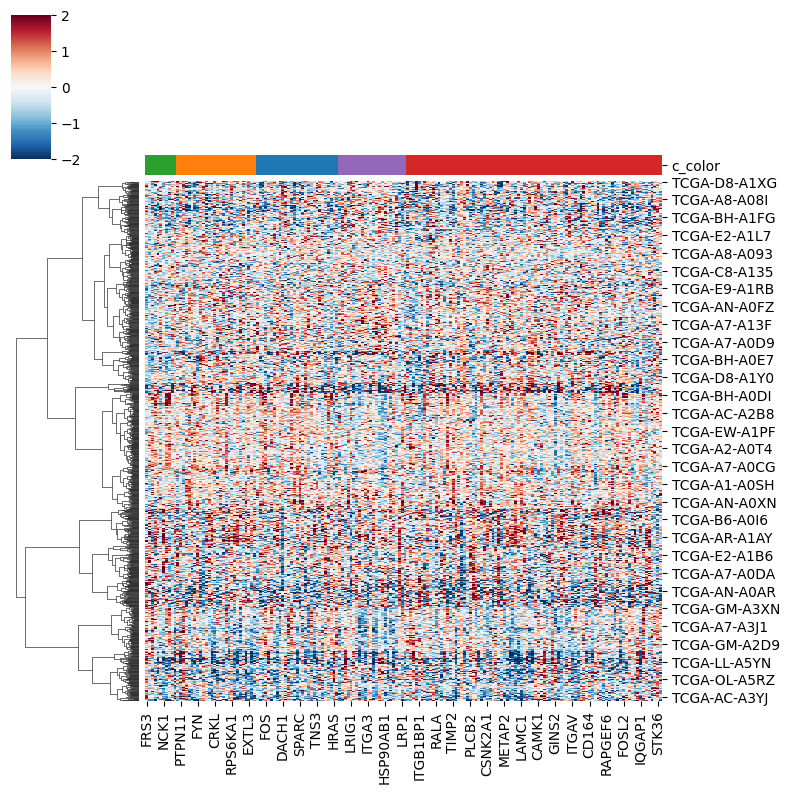

In [90]:
cmx = sns.clustermap(expr_fgf.apply(sT.zscore,axis=1).T,method="ward",cmap="RdBu_r",vmin=-2,vmax=2,figsize=(8,8),\
                     col_colors=response_pgene['c_color'],col_cluster=False)

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


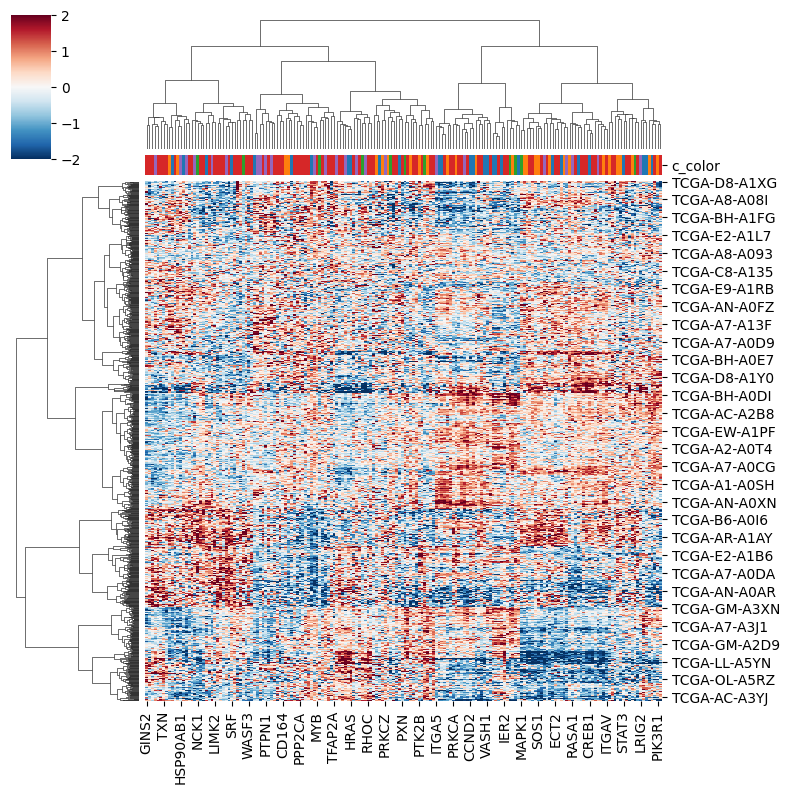

In [91]:
cmx = sns.clustermap(expr_fgf.apply(sT.zscore,axis=1).T,method="ward",cmap="RdBu_r",vmin=-2,vmax=2,figsize=(8,8),\
                     col_colors=response_pgene['c_color'])

In [93]:
expr_fgf.join(response_pgene["ClusterName"])

,TCGA-E9-A1RH,TCGA-C8-A26W,TCGA-AO-A0JJ,TCGA-BH-A0HO,TCGA-BH-A18F,TCGA-C8-A12O,TCGA-AQ-A04H,TCGA-BH-A0HY,TCGA-B6-A40B,TCGA-AO-A125,...,TCGA-B6-A0IG,TCGA-EW-A6SC,TCGA-OL-A66I,TCGA-AO-A0JE,TCGA-BH-A0AU,TCGA-A8-A09G,TCGA-E2-A14X,TCGA-HN-A2OB,TCGA-A8-A09M,ClusterName
FRS3,7.276126,8.501020,7.652031,7.721720,8.035781,7.606301,7.487137,9.185996,9.198348,8.829461,...,8.557215,8.559143,8.917198,7.958507,7.557396,7.121567,8.297293,8.767365,8.456250,1
FGFBP2,3.917085,5.007546,6.445118,4.435142,6.893464,4.636108,4.782902,4.512346,5.165318,4.192082,...,4.469826,5.233220,5.547855,7.079571,4.771752,4.962483,7.453565,5.492623,4.177227,1
FGF18,7.241122,6.725313,6.522825,5.758721,7.123608,6.242683,5.627173,6.500388,6.858660,4.385211,...,5.776444,5.680018,6.343121,7.102072,6.714545,5.321523,5.224114,7.552469,5.748840,1
IL17RD,10.047646,10.101902,11.369269,9.656980,12.000089,9.727976,9.691346,9.390954,9.612600,9.140996,...,9.671930,11.158872,10.607108,8.036232,10.387859,9.741434,11.053295,12.669730,10.487724,1
SHC1,12.014702,12.356203,12.460974,13.234339,13.140231,12.354884,12.283430,12.831427,12.820901,12.414121,...,12.477493,12.904961,12.542073,12.557119,13.521446,12.461031,12.336561,12.805129,13.204903,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LIMK2,11.981753,11.885048,11.741787,12.360184,12.195422,13.202347,10.841630,13.492310,12.119279,11.493393,...,12.169879,11.350827,12.068488,12.410409,11.950576,12.078361,14.527870,12.569307,12.402351,5
CITED2,13.166089,10.751598,13.007094,11.444055,12.312954,10.475207,12.001912,11.538792,13.689603,10.717035,...,12.956397,14.470111,12.259447,11.181092,12.030051,12.141758,12.067274,12.720381,11.903430,5
SGK3,8.130109,11.080970,11.373938,10.300720,9.513109,12.237933,10.468416,8.237771,9.117928,10.808836,...,8.680195,10.143132,10.615090,9.383226,11.797278,8.231582,9.897152,10.896546,10.332405,5
STK36,11.124928,10.728250,10.535237,11.081396,10.793116,10.543687,11.531641,10.412000,11.294536,12.823129,...,10.819344,11.549646,11.295622,10.947649,11.333489,9.537165,9.873908,11.173683,11.987459,5


In [ ]:
fin